In [92]:
import dotenv
from IPython.display import display, Image
from langgraph.types import interrupt, Command
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage
from typing import List, Optional
from pydantic import Field
from typing_extensions import Annotated, TypedDict
from langgraph.checkpoint.memory import MemorySaver

dotenv.load_dotenv()

True

## Model, tools, graph state

In [93]:
class Answer(TypedDict):
    """Answer to a question"""

    answer: Annotated[str, ..., "The answer to the question"]


class Question(TypedDict):
    """Question to ask the user"""

    question: Annotated[str, ..., "The question to ask the user"]
    guidance: Annotated[str, ..., "Guidance to help the user answer the question"]
    answer: Annotated[Optional[str], ...]


class Questions(TypedDict):
    """List of questions to ask the user"""

    questions: List[Question] = Field(description="The questions to ask the user", min_length=3)


# class Answers(TypedDict):
#     """List of answers to questions"""

#     answers: List[Answer] = Field(description="The answers to the questions", min_length=3)


# State - has messages from MessagesState
class GraphState(MessagesState):
    questions: Questions
    # answers: Answers


model = ChatOpenAI(model="gpt-4o-mini")
model_with_json_questions_output = model.with_structured_output(Questions)

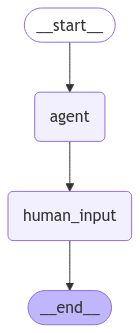

In [94]:
# Node
def generate_questions(state: GraphState):
    sys_msg = SystemMessage("""
You are helpful assistant to generate 3 helpful questions with a short guidance about how to answer them based on given information.
Those questions should be helpful to later generate a character for the tabletop RPG game called "Świat Apokalipsy".
Question should be more specific than general and should help to fill character's sheet like class, skills, items.

You will receive a 4 block of information:
1. basic information which will contain name of the character, age and other basic information.
    example: Moja postać ma na imię Max, ma 25 lat, jest wysokim, szczupłym mężczyzną o ciemnych włosach i niebieskich oczach.
2. history of the character which will contain information about the past and skills of the character gained during the past.
    example: Max urodził się w małej wiosce, gdzie jego rodzina prowadziła gospodarstwo rolne. W wieku 18 lat opuścił rodzinny dom i wyruszył w świat, aby zdobyć nowe doświadczenia. Podczas swoich podróży nauczył się walczyć i przetrwać w trudnych warunkach.
3. Character's traits which will contain information about the character's personality and other traits.
    example: Max jest odważny, lecz nieufny wobec obcych. Jest lojalny wobec swoich przyjaciół i gotów poświęcić się dla nich. Często działa impulsywnie, co prowadzi go do niebezpiecznych sytuacji.
4. Game's world information which will contain information about the world where the game takes place.
    example: Świat postapokaliptycznego przedmieścia Warszawy, gdzie przetrwali unikają stolicy.

Example of questions:
1. Co sprawiło, że Twoja postać przetrwała apokalipsę?
    Pomyśl o umiejętnościach, szczęściu lub okolicznościach, które pozwoliłyby Twojej postaci przetrwać.
2. Jakie wydarzenie z przeszłości Twojej postaci miało największy wpływ na jej obecną postawę?
    Może to być trauma, triumf lub inna sytuacja, która ukształtowała Twoją postać.
3. Kogo Twoja postać straciła podczas apokalipsy i jak to wpłynęło na jej życie?
    Zastanów się nad relacjami i więzami, które zostały zerwane.

Your output should be in Polish language and contain exactly 3 questions.
""")

    questions = model_with_json_questions_output.invoke([sys_msg] + state["messages"])
    return {"messages": [], "questions": questions}


# Node
def human_input(state: GraphState):
    human_message = interrupt("human_input")
    for i, answer in enumerate(human_message["answers"]):
        answer_t = answer["answer"]
        print(state["questions"]["questions"])
        state["questions"]["questions"][i]["answer"] = answer_t

    print(state["questions"])

    return {"messages": state["messages"], "questions": state["questions"]}


workflow = StateGraph(GraphState)

workflow.add_node("agent", generate_questions)
workflow.add_node("human_input", human_input)

workflow.add_edge(START, "agent")
workflow.add_edge("agent", "human_input")
workflow.add_edge("human_input", END)

checkpointer = MemorySaver()

graph = workflow.compile(checkpointer=checkpointer)

display(Image(graph.get_graph().draw_mermaid_png()))

In [95]:
config = {"configurable": {"thread_id": "1"}}

resp = graph.invoke(
    {"messages": "Joseph jest 35 letnim mężczyzną o szerokiej sylwetce bez oka i długimi włosami, nosi opaskę.\n\nZa życia był udanym mechanikiem i prowadził dużą sieć serwisów samochodowych.\n\nJoseph jest bardzo szczerym i wesołym, zawsze znajdzie moment na żart.\n\nOstatnia wojna nuklearna zmasakrowała cały świat, ale cudem ominęła Otwock, który leży przy Warszawie."},
    config=config,
)

for m in resp["messages"]:
    m.pretty_print()

print()
print(resp["questions"])

# print()
# print(resp["answers"])

# print(type(resp["questions"]))

# print()
# print(resp["questions"]["questions"][0]["question"])

================================ Human Message =================================

Joseph jest 35 letnim mężczyzną o szerokiej sylwetce bez oka i długimi włosami, nosi opaskę.

Za życia był udanym mechanikiem i prowadził dużą sieć serwisów samochodowych.

Joseph jest bardzo szczerym i wesołym, zawsze znajdzie moment na żart.

Ostatnia wojna nuklearna zmasakrowała cały świat, ale cudem ominęła Otwock, który leży przy Warszawie.

{'questions': [{'question': 'Jakie umiejętności mechaniczne Joseph wykorzystuje w postapokaliptycznym świecie?', 'guidance': 'Pomyśl o tym, jak jego doświadczenie jako mechanik może pomóc w przetrwaniu, naprawie sprzętu lub pojazdów.', 'answer': ''}, {'question': 'Jakie relacje z innymi postaciami Joseph miał przed apokalipsą i jak wpłynęły one na jego obecne życie?', 'guidance': 'Zastanów się nad osobami, które były ważne w jego życiu, ich stratą lub wsparciem, i jak te relacje kształtują jego osobowość teraz.', 'answer': ''}, {'question': 'Jak Joseph radzi sobi

In [96]:
resp = graph.invoke(
    Command(
        resume={
            "answers": [
                {
                    "answer": "Joseph przetrwał apokalipsę dzięki swojemu sprytowi i umiejętnościom przetrwania."
                },
                {
                    "answer": "Stara się unikać tematów związanych z przeszłością, ale wciąż go prześladują koszmary z przeszłości."
                },
                {
                    "answer": "Zestaw narzędzi, który dostał od swojego ojca, który zginął podczas wojny."
                },
            ],
        },
    ),
    config=config,
)

for m in resp["messages"]:
    m.pretty_print()

print()

print(resp["questions"])

[{'question': 'Jakie umiejętności mechaniczne Joseph wykorzystuje w postapokaliptycznym świecie?', 'guidance': 'Pomyśl o tym, jak jego doświadczenie jako mechanik może pomóc w przetrwaniu, naprawie sprzętu lub pojazdów.', 'answer': ''}, {'question': 'Jakie relacje z innymi postaciami Joseph miał przed apokalipsą i jak wpłynęły one na jego obecne życie?', 'guidance': 'Zastanów się nad osobami, które były ważne w jego życiu, ich stratą lub wsparciem, i jak te relacje kształtują jego osobowość teraz.', 'answer': ''}, {'question': 'Jak Joseph radzi sobie z brakiem oka, czy ma jakieś specjalne strategie lub przedmioty, które mu w tym pomagają?', 'guidance': 'Rozważ, jak brak jednego oka wpłynął na jego zdolności i jakie adaptacje musiał wprowadzić w swoim życiu codziennym.', 'answer': ''}]
[{'question': 'Jakie umiejętności mechaniczne Joseph wykorzystuje w postapokaliptycznym świecie?', 'guidance': 'Pomyśl o tym, jak jego doświadczenie jako mechanik może pomóc w przetrwaniu, naprawie sprzęt